In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
from PIL import Image
import cv2
import numpy as np
import re
import Levenshtein
from tabulate import tabulate
import pandas as pd

In [2]:
# Replace 'path_to_your_image' with the actual path to your image file
image_path_1 = r"/kaggle/input/image-file/page2.jpg"
image_path_2 = r"/kaggle/input/image-file/1-Srikakulam_1-Ichchapuram_1.jpg"

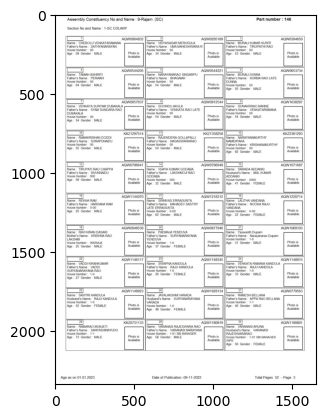

In [3]:
image = Image.open(image_path_1)
plt.imshow(image)

In [5]:
def find_long_straight_lines(image_path, min_line_length):

    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray_image, 50, 150, apertureSize=3)
    lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=100, minLineLength=min_line_length, maxLineGap=5)
    
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

    plt.imshow(image)
    
    return lines

35


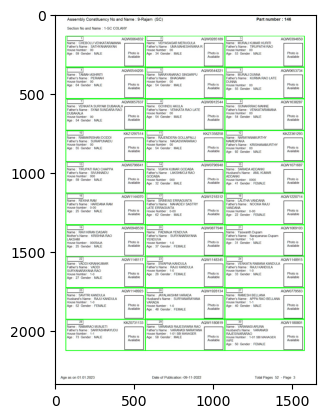

In [6]:
lines_1 = find_long_straight_lines(image_path_1, min_line_length=500)
print(len(lines_1))

46


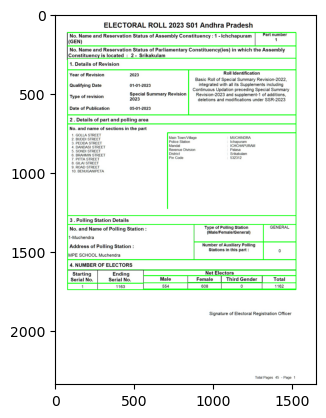

In [7]:
lines_2 = find_long_straight_lines(image_path_2, min_line_length=200)
print(len(lines_2))

In [8]:
def corrected_contours(image_path, lines, min_line_length):
    
    lines = np.squeeze(np.array(lines))
    lines_new = np.zeros(lines.shape)

    for i in range(lines.shape[1] // 2):
        column_data = np.append(lines[:, i], lines[:, i + 2])
        unique_elements = np.unique(column_data)
        dif_mask = np.diff(unique_elements) < 10
        dif_mask = np.append(dif_mask, False)
        consec_count = 1
        modified_array = np.zeros(len(unique_elements))

        for k, m in enumerate(dif_mask):

            if m:
                consec_count += 1

            else:
                mean_value = np.sum(unique_elements[k - consec_count + 1:k + 1]) // consec_count
                modified_array[k - consec_count + 1:k + 1] = mean_value
                consec_count = 1

        for j in range(lines.shape[0]):
            lines_new[j, i] = modified_array[np.where(unique_elements == lines[j, i])]
            lines_new[j, i + 2] = modified_array[np.where(unique_elements == lines[j, i + 2])]
            
    lines_new = lines_new.astype(int)

    image = cv2.imread(image_path)
    colors = np.random.randint(0, 255, size=(len(lines_new), 3))
    
    for l, line in enumerate(lines_new):
        x1, y1, x2, y2 = line
        color = colors[l].tolist()
        cv2.line(image, (x1, y1), (x2, y2), color, 2)

    plt.imshow(image)
    
    return lines_new

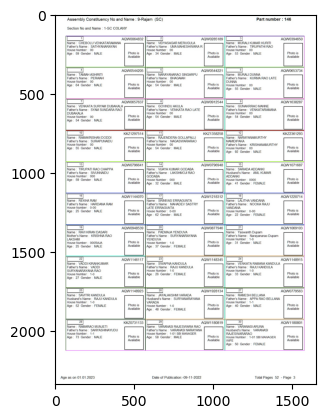

In [9]:
corrected_lines = corrected_contours(image_path_1, lines_1, 100)

In [10]:
horz_lines = []
vert_lines = []

for line in corrected_lines:
    x1, y1, x2, y2 = line
    if y1 == y2:
        horz_lines.append(line)
    elif x1 == x2:
        vert_lines.append(line)
    
horz_lines = np.array(horz_lines)
vert_lines = np.array(vert_lines)

sorted_horz_indices = np.argsort(horz_lines[:, 1])
sorted_vert_indices = np.argsort(vert_lines[:, 0])

sorted_horz = horz_lines[sorted_horz_indices]
sorted_vert = vert_lines[sorted_vert_indices]

for line in sorted_horz:
    if line[0] not in sorted_vert[:, 0]:
        line[0] = np.max(sorted_vert[:, 0][sorted_vert[:, 0] < line[0]])
        
    elif line[2] not in sorted_vert[:, 0]:
        line[2] = np.min(sorted_vert[:, 0][sorted_vert[:, 0] > line[2]])
                         
for line in sorted_vert:
    if line[3] not in sorted_horz[:, 1]:
        line[3] = np.max(sorted_horz[:, 1][sorted_horz[:, 1] < line[3]])
        
    elif line[1] not in sorted_horz[:, 1]:
        line[1] = np.min(sorted_horz[:, 1][sorted_horz[:, 1] > line[1]])
        
                         
unique_horz = np.unique(sorted_horz, axis=0)
unique_vert = np.unique(sorted_vert, axis=0)
                         
final_lines = np.concatenate((unique_horz, unique_vert), axis=0)
print(final_lines)
print(len(final_lines))

[[  68  139 1572  139]
 [  68  335 1572  335]
 [  68  535 1572  535]
 [  68  735 1572  735]
 [  68  932 1572  932]
 [  68 1131 1572 1131]
 [  68 1332 1572 1332]
 [  68 1529  570 1529]
 [  68 1730 1572 1730]
 [  68 1928 1572 1928]
 [  68 2127 1572 2127]
 [ 570 1529 1572 1529]
 [ 570 1928 1572 1928]
 [  68 2127   68  139]
 [ 570 2127  570  139]
 [1071 2127 1071  139]
 [1572 2127 1572  139]]
17


[  68  139 1572  139]
[  68  335 1572  335]
[  68  535 1572  535]
[  68  735 1572  735]
[  68  932 1572  932]
[  68 1131 1572 1131]
[  68 1332 1572 1332]
[  68 1529  570 1529]
[  68 1730 1572 1730]
[  68 1928 1572 1928]
[  68 2127 1572 2127]
[ 570 1529 1572 1529]
[ 570 1928 1572 1928]
[  68 2127   68  139]
[ 570 2127  570  139]
[1071 2127 1071  139]
[1572 2127 1572  139]


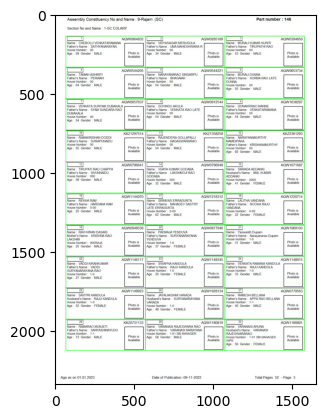

In [11]:
image = cv2.imread(image_path_1)

for l, line in enumerate(final_lines):
    print(line)
    x1, y1, x2, y2 = line
    cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        
plt.imshow(image)

In [12]:
patch = image[139:335, 68:570]

# Convert the patch to grayscale for better OCR results (optional)
gray_patch = cv2.cvtColor(patch, cv2.COLOR_BGR2GRAY)

# Perform OCR on the extracted patch using pytesseract
extracted_text = pytesseract.image_to_string(gray_patch)

# Print or process the extracted text as needed
print(extracted_text)

 

Name: CHEBOLU VENKATARAMANA
Father's Name : SATHYANARAYAN
House Number : 00

Age: 59 Gender: MALE

AQW0064832

Photo is

Available

 

 

 



In [13]:
split_data = {}
count = 0
for index_horz, horz_seg in enumerate(unique_horz):
    for vert_seg in unique_vert:
        if vert_seg[1] == horz_seg[1] or vert_seg[3] == horz_seg[1]:
            x1 = vert_seg[0]
            y1 = horz_seg[1]

            for index_vert, horz_seg_2 in enumerate(unique_horz[index_horz + 1:]):
                if horz_seg_2[0] == vert_seg[0] or horz_seg_2[2] == vert_seg[0]:
                    y2 = horz_seg_2[1]

                for vert_seg_2 in unique_vert:        #[index_vert + 1:]
                    min_y = min(vert_seg_2[1], vert_seg_2[3])
                    max_y = max(vert_seg_2[1], vert_seg_2[3])

                    if min_y <= y1 and max_y >= y2:
                        x2 = vert_seg_2[0]
                        #print(x1, y1, x2, y2)

                        if (x1 < x2) and (y1 < y2):
                            patch = image[y1:y2, x1:x2]
                            gray_patch = cv2.cvtColor(patch, cv2.COLOR_BGR2GRAY)

                            custom_config = r'--psm 11'
                            extracted_text = pytesseract.image_to_string(gray_patch, config = custom_config)
                            
                            block_color = 200  # Adjust the grayscale intensity (0-255)

                            coordinates = [(x1, y1), (x2, y1), (x2, y2), (x1, y2)]

                            cv2.fillPoly(image, [np.array(coordinates)], block_color)

                            split_data[count] = extracted_text
                            count += 1

In [16]:
Names = []
ForH_Names = []
Ages = []
Genders = []
IDs = []

for block, text in enumerate(split_data.values()):
    filtered_text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    words = filtered_text.split()
    if len(words) > 0:
        print(block, words)

        for index, word in enumerate(words):
            if Levenshtein.distance(word, "Name") <= 1:
                Name = words[index + 1] + " " + words[index + 2]
                Names.append(Name)
                ID = []

                for i in range(index):
                    ID.append(words[i])
 
                IDs.append(ID)
    
                break

        for index, word in enumerate(words):
            if Levenshtein.distance(word, "Fathers") <= 1:
                if index + 1 < len(words):
                    if words[index + 3] != "House":
                        ForH_Name = words[index + 2] + " " + words[index + 3]
                    else:
                        ForH_Name = words[index + 2]
                    ForH_Names.append(ForH_Name)

            if Levenshtein.distance(word, "Husbands") <= 1:
                if index + 1 < len(words):
                    if words[index + 3] != "House":
                        ForH_Name = words[index + 2] + " " + words[index + 3]
                    else:
                        ForH_Name = words[index + 2]
                    ForH_Names.append(ForH_Name)
                    
            if Levenshtein.distance(word, "Mothers") <= 1:
                if index + 1 < len(words):
                    if words[index + 3] != "House":
                        ForH_Name = words[index + 2] + " " + words[index + 3]
                    else:
                        ForH_Name = words[index + 2]
                    ForH_Names.append(ForH_Name)


        if "FEMALE" in words:
            Genders.append("FEMALE")
        elif "MALE" in words:
            Genders.append("MALE")

        for item in words:
            if re.match(r'\d+', item):
                Age = int(item)
                if Age > 19 and Age < 100:
                    Ages.append(Age)              

print(ForH_Names)
print(Names)
print(Ages)
print(Genders)
print(IDs)

print(len(ForH_Names), len(Names), len(Ages), len(Genders), len(IDs))

0 ['AQW0064832', 'Name', 'CHEBOLU', 'VENKATARAMANA', 'Fathers', 'Name', 'SATHYANARAYAN', 'House', 'Number', '00', 'Photo', 'is', 'Age', '59', 'Gender', 'MALE', 'Available']
1 ['AQW0285189', 'Name', 'VIDYASAGAR', 'MERUGULA', 'Fathers', 'Name', 'UMA', 'MAHESHWARA', 'R', 'House', 'Number', '00', '34', 'Gender', 'MALE', 'Photo', 'is', 'Age', 'Available']
2 ['AQW0394650', 'Name', 'MURALI', 'KUMAR', 'KURITI', 'Fathers', 'Name', 'TIRUPATHI', 'RAO', 'House', 'Number', '00', '53', 'Gender', 'MALE', 'Photo', 'is', 'Age', 'Available']
3 ['AQW0544205', 'Name', 'TAMIAH', 'ASHIRITI', 'Fathers', 'Name', 'PERAIAH', 'House', 'Number', '00', 'MALE', 'Photo', 'is', 'Age', '64', 'Gender', 'Available']
4 ['AQW0544221', 'Name', 'NARAYANARAO', 'SINGARPU', 'Fathers', 'Name', 'BHAGAIAH', 'House', 'Number', '00', 'MALE', 'Photo', 'is', 'Age', '54', 'Gender', 'Available']
5 ['AQW0653734', 'Name', 'MURALI', 'DUNNA', 'Fathers', 'Name', 'KURMA', 'RAO', 'LATE', 'DUNNA', 'House', 'Number', '00', 'Photo', 'is', '55', 

In [18]:
data = {
    'Name': Names,
    'Father or Husband Name': ForH_Names,
    'Age': Ages,
    'Gender': Genders,
    'ID' : IDs
}

df = pd.DataFrame(data)

print(df)

                         Name Father or Husband Name  Age  Gender  \
0       CHEBOLU VENKATARAMANA          SATHYANARAYAN   59    MALE   
1         VIDYASAGAR MERUGULA         UMA MAHESHWARA   34    MALE   
2                MURALI KUMAR          TIRUPATHI RAO   53    MALE   
3             TAMIAH ASHIRITI                PERAIAH   64    MALE   
4        NARAYANARAO SINGARPU               BHAGAIAH   54    MALE   
5                MURALI DUNNA              KURMA RAO   55    MALE   
6              VENKATA SURYAM           SYAM SUNDARA   54    MALE   
7                  INDU AKULA            VENKATA RAO   54    MALE   
8             GUNAKRRAO MANNE          VENKATARAMANA   54    MALE   
9           RAMAKRISHAN DODDI            SURAPUNAIDU   55    MALE   
10       RAJENDERA GOLLAPALLI           NAGASWARARAO   54    MALE   
11  NARAYANAMURTHY MAMIDIPAKA         KRISHANAMURTHY   92    MALE   
12               TIRUPATI RAO             SIVUNNAIDU   59    MALE   
13               VIJAYA KUMAR     

In [20]:
print(tabulate(df, headers='keys', tablefmt='plain'))

    Name                       Father or Husband Name      Age  Gender    ID
 0  CHEBOLU VENKATARAMANA      SATHYANARAYAN                59  MALE      ['AQW0064832']
 1  VIDYASAGAR MERUGULA        UMA MAHESHWARA               34  MALE      ['AQW0285189']
 2  MURALI KUMAR               TIRUPATHI RAO                53  MALE      ['AQW0394650']
 3  TAMIAH ASHIRITI            PERAIAH                      64  MALE      ['AQW0544205']
 4  NARAYANARAO SINGARPU       BHAGAIAH                     54  MALE      ['AQW0544221']
 5  MURALI DUNNA               KURMA RAO                    55  MALE      ['AQW0653734']
 6  VENKATA SURYAM             SYAM SUNDARA                 54  MALE      ['AQW0657637']
 7  INDU AKULA                 VENKATA RAO                  54  MALE      ['Ls', 'W0912544']
 8  GUNAKRRAO MANNE            VENKATARAMANA                54  MALE      ['287']
 9  RAMAKRISHAN DODDI          SURAPUNAIDU                  55  MALE      ['Lo', '10', 'KKZ1297514']
10  RAJENDERA GOLLAPALLI

In [21]:
df.to_csv('/kaggle/working/grid.csv', index=False)